**Menambahkan File Crawling Data**

In [3]:
import pandas as pd

# Membaca file CSV pertama dan mengambil kolom yang diperlukan
df1 = pd.read_csv('/content/sample_data/crawling1.csv', usecols=['full_text', 'username'])

# Membaca file CSV kedua dan mengambil kolom yang diperlukan
df2 = pd.read_csv('/content/sample_data/crawling2.csv', usecols=['full_text', 'username'])

# Menggabungkan kedua dataframe secara vertikal
combined_df = pd.concat([df1, df2], ignore_index=True)

# Menyimpan dataframe yang sudah digabungkan ke file CSV baru (opsional)
combined_df.to_csv('combined_dataset.csv', index=False)

# Menampilkan beberapa baris pertama dari dataframe yang sudah digabungkan
print(combined_df.head())


                                           full_text        username
0    @saedah789 @fmtoday Hahaha . Tepat kena setepek        sirsazly
1                    @ShahnazAzizTT @jef1808 Setuju         sirsazly
2  @ShahnazAzizTT @jef1808 semoga semua pihak leb...        sirsazly
3                           @stolitzLoverr__ Gn btw!  Endermanpro200
4  @andikamalreza untung aku lebih dari 2 3. dah ...  einschleimer29


**Instal Package Sastrawi untuk melakukan Preprocesing Data**

In [4]:
pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.5 MB/s eta 0:00:00


In [5]:
import re
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Mengunduh data NLTK yang diperlukan
nltk.download('punkt')
nltk.download('wordnet')

# Inisialisasi stop words bahasa Indonesia dan lemmatizer
factory = StopWordRemoverFactory()
stop_words = set(factory.get_stop_words())
lemmatizer = WordNetLemmatizer()

# Fungsi pra-pemrosesan
def preprocess_text(text):
    # Menghapus kata yang diawali dengan @
    text = re.sub(r'@\w+', '', text)

    # Menghapus karakter khusus dan angka
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)

    # Mengubah teks menjadi huruf kecil
    text = text.lower()

    # Tokenisasi teks
    tokens = word_tokenize(text)

    # Menghapus stop words dan melakukan lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Menggabungkan token kembali menjadi string teks
    processed_text = ' '.join(tokens)

    return processed_text

# Menerapkan pra-pemrosesan pada kolom 'full_text' dari dataframe gabungan
combined_df['processed_text'] = combined_df['full_text'].apply(preprocess_text)

# Menyimpan dataframe yang sudah diproses ke file CSV baru
combined_df.to_csv('processed_combined_dataset.csv', index=False)

# Menampilkan beberapa baris pertama dari dataframe yang sudah diproses
print(combined_df.head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                           full_text        username  \
0    @saedah789 @fmtoday Hahaha . Tepat kena setepek        sirsazly   
1                    @ShahnazAzizTT @jef1808 Setuju         sirsazly   
2  @ShahnazAzizTT @jef1808 semoga semua pihak leb...        sirsazly   
3                           @stolitzLoverr__ Gn btw!  Endermanpro200   
4  @andikamalreza untung aku lebih dari 2 3. dah ...  einschleimer29   

                                      processed_text  
0                          hahaha tepat kena setepek  
1                                             setuju  
2         semoga semua pihak lebih peka dimasa depan  
3                                             gn btw  
4  untung aku lebih dah lah masuk kursi pemerinta...  


Karena data crawling belum memiliki sentiment, maka hasil preprocesing perlu ditambahkan sentiment

**Penambahan sentiment pada file preprocesing**

In [6]:
import pandas as pd

df = pd.read_csv('/content/Datasentimen.csv')
df.head()

,full_text,username,processed_text,sentiment
0,@saedah789 @fmtoday Hahaha . Tepat kena setepek,sirsazly,hahaha tepat kena setepek,NEGATIF
1,@ShahnazAzizTT @jef1808 Setuju,sirsazly,setuju,POSITIF
2,@ShahnazAzizTT @jef1808 semoga semua pihak leb...,sirsazly,semoga semua pihak lebih peka dimasa depan,POSITIF
3,@stolitzLoverr__ Gn btw!,Endermanpro200,gn btw,NEGATIF
4,@andikamalreza untung aku lebih dari 2 3. dah ...,einschleimer29,untung aku lebih dah lah masuk kursi pemerinta...,POSITIF


**Klasifikasi dan Evaluasi model menggunakan metode Naive Bayes**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Membaca data dari CSV yang telah ditambahkan kolom sentimen
df = pd.read_csv('/content/Datasentimen.csv')

# Mengatasi nilai-nilai yang hilang (NaN)
df['processed_text'] = df['processed_text'].fillna('')
df = df.dropna(subset=['sentiment'])

# Pra-pemrosesan teks
df['processed_text'] = df['processed_text'].apply(preprocess_text)

# Memisahkan fitur dan label
X = df['processed_text']
y = df['sentiment']

# Memisahkan data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi TF-IDF Vectorizer dengan bigram dan trigram
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Menyesuaikan dan mengubah data latih menjadi fitur TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Mengubah data uji menjadi fitur TF-IDF
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Inisialisasi model Multinomial Naive Bayes dengan smoothing parameter
nb_classifier = MultinomialNB(alpha=0.1)

# Melatih model dengan data latih
nb_classifier.fit(X_train_tfidf, y_train)

# Memprediksi sentimen data uji
y_pred = nb_classifier.predict(X_test_tfidf)

# Mencetak hasil sentimen
results = pd.DataFrame({'Text': X_test, 'Actual Sentiment': y_test, 'Predicted Sentiment': y_pred})
print(results)

# Menghitung akurasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi model: {accuracy * 100:.2f}%")

# Menampilkan laporan klasifikasi
print("\nLaporan klasifikasi:")
print(classification_report(y_test, y_pred))

# Menampilkan matriks kebingungan
print("\nMatriks kebingungan:")
print(confusion_matrix(y_test, y_pred))

                                                  Text Actual Sentiment  \
96   lha emang jkw segoblok klo ditinggalin diam aj...          NEGATIF   
15   gasskeun lah bawa mahkamah pidana internasiona...          NEGATIF   
30   punya talenta kebuang sia plagiat non stop tau...          POSITIF   
160                       kelapa orked nak duit balikk          NEGATIF   
129  betul tu situasi sekarang junta kena buli rama...          POSITIF   
116  brigade izzuddin al qassam pukul pagi kemarin ...          NEGATIF   
70   in shaa allah cepat lambat lambat cepat freepa...          POSITIF   
173                             idihhh kuat nangis aja          POSITIF   
177  cerdik berani luar biasa taktik taruhannya nya...          NEGATIF   
45        pengamat balap tarkam kok ngomentari politik          NEGATIF   
67    yg nonton bl gl buat fetish baku hantam yu kntol          NEGATIF   
185                                         apa banget          POSITIF   
167  maksiat yg hasilnya 

**Visualisasi Data Model**

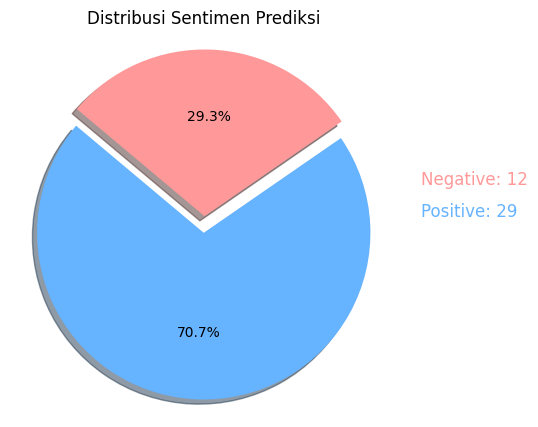

In [20]:
import matplotlib.pyplot as plt

# Hitung jumlah prediksi positif dan negatif
# Make sure 'positive' and 'negative' match the labels in your 'y_pred' array
positive_count = (y_pred == 'NEGATIF').sum()
negative_count = (y_pred == 'POSITIF').sum()

# Data untuk grafik pie
labels = 'Positif', 'Negatif'
sizes = [positive_count, negative_count]
colors = ['#66b3ff','#ff9999']
explode = (0.1, 0)  # Meledakkan irisan pertama (Positive)

# Membuat grafik pie
plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode,  colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribusi Sentimen Prediksi')
plt.text(1.3, 0.19, f'Negative: {sizes[1]}',  fontsize=12, color='#ff9999')
plt.text(1.3, 0, f'Positive: {sizes[0]}',  fontsize=12, color='#66b3ff')

plt.show()